In [ ]:
#Figure 5a

Original line length (degrees): 8.819929780181814
Reprojected line length (meters): 8.819929780181814


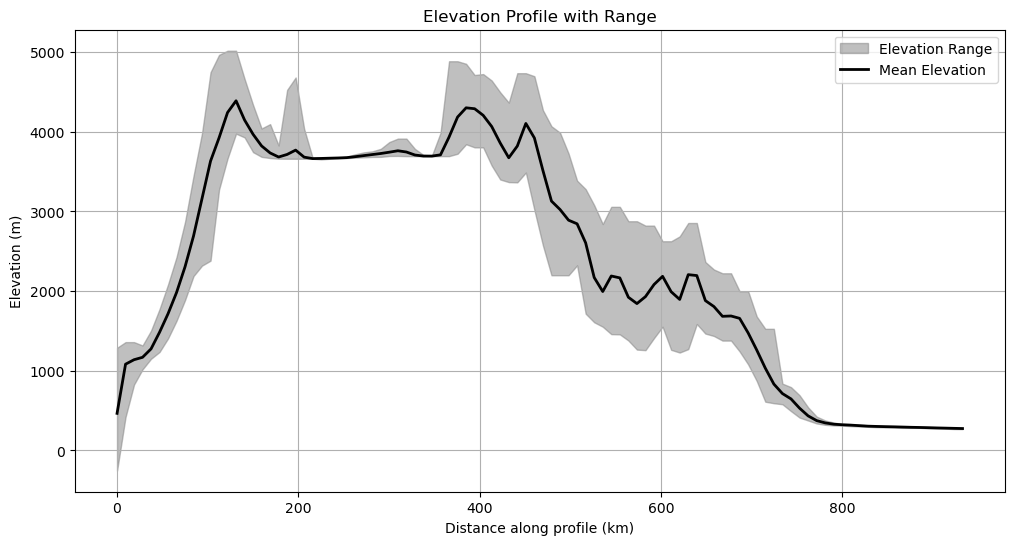

Elevation profile saved as: /Users/jianpingzhou/work/Papers/small_rivers/catchment/elevation_profile.pdf


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import LineString, Point
from shapely.ops import transform
from pyproj import CRS, Transformer, Geod

# Step 1: Load the profile line from the shapefile
shapefile_path = '/Users/jianpingzhou/work/Papers/small_rivers/catchment/profile2.shp'
gdf = gpd.read_file(shapefile_path)

# Assuming the shapefile contains a single line geometry
profile_line = gdf.geometry[0]  # Extract the LineString

# Step 2: Open the DEM and reproject the line to match the DEM CRS
dem_path = '/Users/jianpingzhou/work/Papers/small_rivers/catchment/South_America.tif'
with rasterio.open(dem_path) as dem:
    dem_crs = dem.crs  # DEM's CRS
    
    # Transform the line to match the DEM's CRS
    source_crs = CRS(gdf.crs)  # CRS of the shapefile
    target_crs = CRS(dem_crs)
    transformer = Transformer.from_crs(source_crs, target_crs, always_xy=True)
    line_reprojected = transform(transformer.transform, profile_line)

    # Debug: Check the length before and after reprojection
    print(f"Original line length (degrees): {profile_line.length}")
    print(f"Reprojected line length (meters): {line_reprojected.length}")

    # Step 3: Sample points along the profile based on real-world distance
    num_samples = 100  # Number of sampling points along the profile
    line_length = line_reprojected.length  # Total length in DEM CRS (meters)
    
    # Generate evenly spaced distances along the line
    sampled_distances = np.linspace(0, line_length, num_samples)
    profile_points = [line_reprojected.interpolate(d) for d in sampled_distances]

    # Prepare geod object for distance calculation
    geod = Geod(ellps='WGS84')
    distances = [0]  # Store distances in km
    min_elevations = []
    mean_elevations = []
    max_elevations = []
    
    # Step 4: Extract elevation values along the profile
    for i, point in enumerate(profile_points):
        px, py = point.x, point.y  # Get point coordinates in DEM CRS
        
        # Compute distance from start using geographic coordinates
        if i > 0:
            prev_point = profile_points[i - 1]
            _, _, dist = geod.inv(prev_point.x, prev_point.y, px, py)
            distances.append(distances[-1] + dist / 1000.0)  # Convert meters to km
        
        # Convert to DEM pixel coordinates
        col, row = ~dem.transform * (px, py)  # Use (x, y) → (col, row) transformation
        row, col = int(row), int(col)  # Convert to integers

        # Debug: Check if points fall within the DEM boundaries
        if not (0 <= row < dem.height and 0 <= col < dem.width):
            print(f"Point ({px}, {py}) is out of DEM bounds, skipping.")
            min_elevations.append(np.nan)
            mean_elevations.append(np.nan)
            max_elevations.append(np.nan)
            continue
        
        # Extract elevation values around the point
        elevation_values = dem.read(1, window=((row - 5, row + 6), (col - 5, col + 6)))
        elevation_values = elevation_values[elevation_values != dem.nodata]
        
        if elevation_values.size > 0:
            min_elevations.append(elevation_values.min())
            mean_elevations.append(elevation_values.mean())
            max_elevations.append(elevation_values.max())
        else:
            min_elevations.append(np.nan)
            mean_elevations.append(np.nan)
            max_elevations.append(np.nan)

# Step 5: Plot the profile and save it as a PDF
output_pdf_path = '/Users/jianpingzhou/work/Papers/small_rivers/catchment/elevation_profile.pdf'

plt.figure(figsize=(12, 6))
plt.fill_between(distances, min_elevations, max_elevations, color='gray', alpha=0.5, label='Elevation Range')
plt.plot(distances, mean_elevations, color='black', linewidth=2, label='Mean Elevation')
plt.xlabel('Distance along profile (km)')
plt.ylabel('Elevation (m)')
plt.title('Elevation Profile with Range')
plt.legend()
plt.grid(True)

# Save plot as PDF
plt.savefig(output_pdf_path, format='pdf', dpi=300, bbox_inches='tight')
plt.show()

print(f"Elevation profile saved as: {output_pdf_path}")

In [ ]:
#Figure 5c

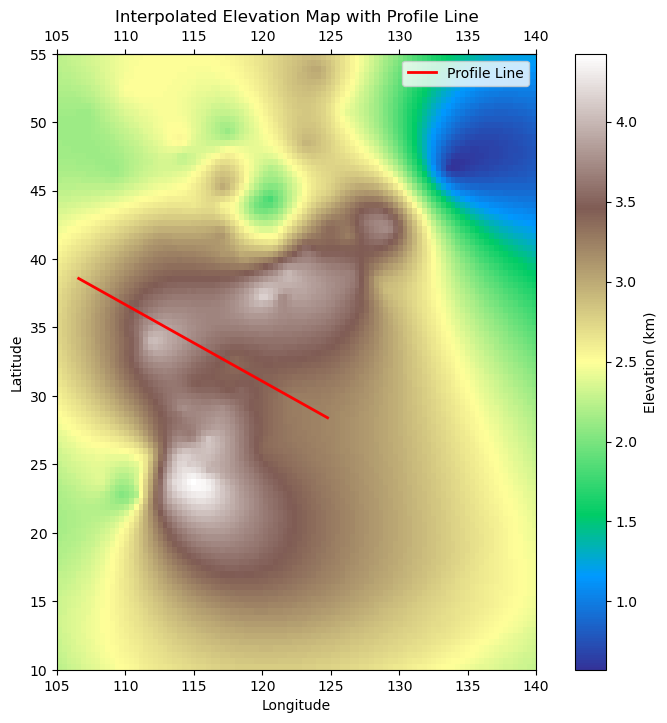

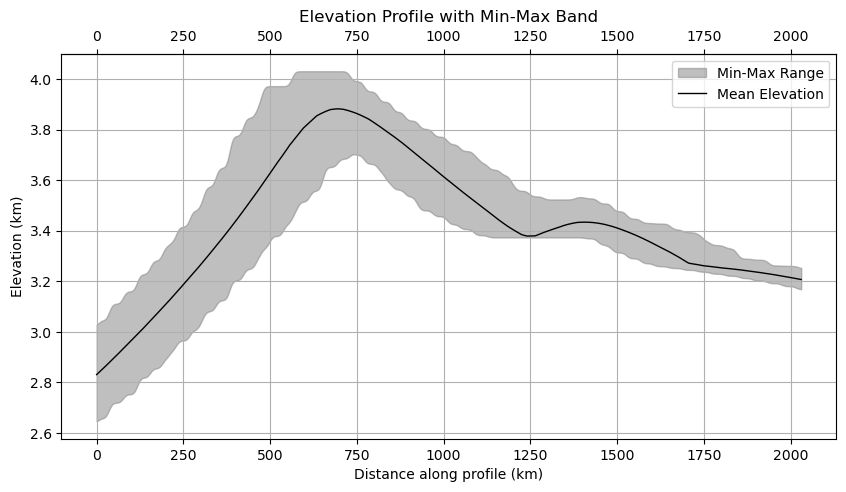

Plots saved to: ./plots


In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from scipy.spatial import cKDTree
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage import gaussian_filter1d
from pyproj import Geod
from pykrige.ok import OrdinaryKriging

# File paths
coastline_shapefile = '/Applications/GPlates_2.5.0/GeoData/FeatureCollections/Coastlines/Shapefile/Global_EarthByte_GPlates_PresentDay_Coastlines_Polyline.shp'
profile_shapefile_path = '/Users/jianpingzhou/work/Papers/small_rivers/catchment/profile_Ff.shp'
file_path = '/Users/jianpingzhou/work/Papers/Andean-type/data/Whole_E_Asia.csv'

# Output directory
output_dir = "./plots"
os.makedirs(output_dir, exist_ok=True)

# Load coastline
coastline_gdf = gpd.read_file(coastline_shapefile)

# Load paleo elevation data
df = pd.read_csv(file_path)
df['Predicted_Paleo_Elevation'] = df['Predicted_Paleo_Elevation'].astype(float)
df = df[(df['Age'] >= 150) & (df['Age'] <= 170)]

# Group data by Age, Lat, Lon
grouped = (
    df.groupby(['Age', 'Lat', 'Lon'])['Predicted_Paleo_Elevation']
    .agg(['median', 'std'])
    .reset_index()
    .rename(columns={'median': 'Median_Predicted_Paleo_Elevation', 'std': 'Error_Predicted_Paleo_Elevation'})
)

# Kriging interpolation
def interpolate_paleo_elevation_kriging(df, resolution=100):
    lon_min, lon_max = 105, 140  # Interpolation area longitude bounds
    lat_min, lat_max = 10, 55    # Interpolation area latitude bounds

    lon_grid = np.linspace(lon_min, lon_max, resolution)
    lat_grid = np.linspace(lat_min, lat_max, resolution)

    points_lon = df['Lon'].values
    points_lat = df['Lat'].values
    values = df['Median_Predicted_Paleo_Elevation'].values

    kriging_model = OrdinaryKriging(
        points_lon, points_lat, values,
        variogram_model='spherical',
        verbose=False, enable_plotting=False
    )

    paleo_elevation_grid, _ = kriging_model.execute('grid', lon_grid, lat_grid)
    return lon_grid, lat_grid, paleo_elevation_grid

# Extract elevation profile
def extract_elevation_profile(shapefile_path, lon_grid, lat_grid, paleo_elevation_grid):
    profile_gdf = gpd.read_file(shapefile_path)
    if profile_gdf.geometry.iloc[0].geom_type != 'LineString':
        raise ValueError("Shapefile must contain a LineString geometry.")
    
    line = profile_gdf.geometry.iloc[0]
    num_samples = 500
    profile_points = np.array([line.interpolate(i / num_samples, normalized=True).coords[0] for i in range(num_samples + 1)])
    
    interp_func = RegularGridInterpolator((lat_grid, lon_grid), paleo_elevation_grid, method='linear')
    elevation_values = interp_func(profile_points[:, [1, 0]])
    
    N = 3
    min_elevations, max_elevations = [], []
    for point in profile_points:
        lat_idx = np.abs(lat_grid - point[1]).argmin()
        lon_idx = np.abs(lon_grid - point[0]).argmin()
        
        elevation_window = paleo_elevation_grid[max(0, lat_idx - N):min(lat_idx + N + 1, paleo_elevation_grid.shape[0]),
                                                max(0, lon_idx - N):min(lon_idx + N + 1, paleo_elevation_grid.shape[1])]
        min_elevations.append(np.nanmin(elevation_window))
        max_elevations.append(np.nanmax(elevation_window))
    
    min_elevations = gaussian_filter1d(min_elevations, sigma=2)
    max_elevations = gaussian_filter1d(max_elevations, sigma=2)
    
    geod = Geod(ellps="WGS84")
    distances = [0]
    for i in range(1, len(profile_points)):
        _, _, dist = geod.inv(profile_points[i-1][0], profile_points[i-1][1], profile_points[i][0], profile_points[i][1])
        distances.append(distances[-1] + dist / 1000)
    
    # Show and save interpolation map
    plt.figure(figsize=(10, 8))
    plt.imshow(paleo_elevation_grid, extent=[lon_grid.min(), lon_grid.max(), lat_grid.min(), lat_grid.max()], origin='lower', cmap='terrain')
    plt.plot(profile_points[:, 0], profile_points[:, 1], 'r-', linewidth=2, label='Profile Line')
    plt.colorbar(label='Elevation (km)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.title('Interpolated Elevation Map with Profile Line')
    plt.gca().secondary_xaxis('top')
    plt.savefig(os.path.join(output_dir, 'interpolated_elevation_map.pdf'))
    plt.show()
    
    # Show and save extracted elevation profile
    plt.figure(figsize=(10, 5))
    plt.fill_between(distances, min_elevations, max_elevations, color='gray', alpha=0.5, label='Min-Max Range')
    plt.plot(distances, elevation_values, linestyle='-', color='black', linewidth=1, label='Mean Elevation')
    plt.xlabel('Distance along profile (km)')
    plt.ylabel('Elevation (km)')
    plt.title('Elevation Profile with Min-Max Band')
    plt.grid()
    plt.legend()
    plt.gca().secondary_xaxis('top')
    plt.savefig(os.path.join(output_dir, 'M_170-150_elevation_profile.pdf'))
    plt.show()

# Run interpolation and extract elevation profile
lon_grid, lat_grid, paleo_elevation_grid = interpolate_paleo_elevation_kriging(grouped)
extract_elevation_profile(profile_shapefile_path, lon_grid, lat_grid, paleo_elevation_grid)

print(f"Plots saved to: {output_dir}")


In [ ]:
#Figure 5e

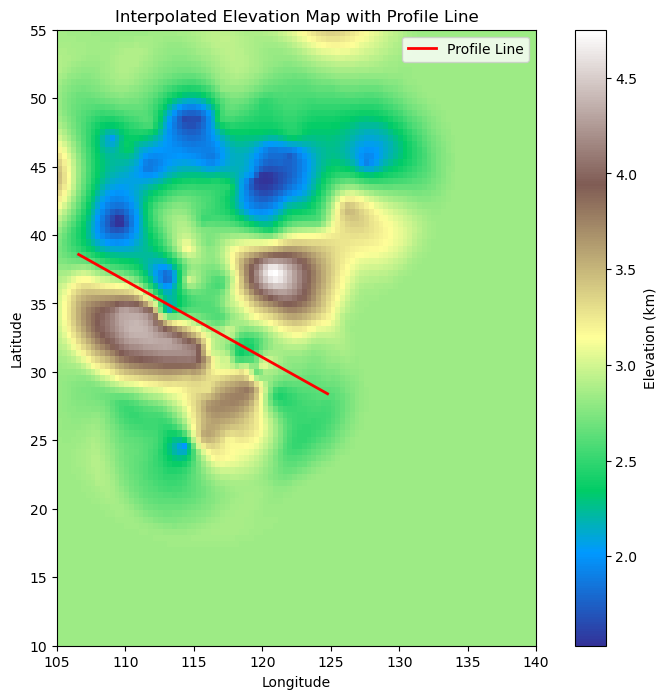

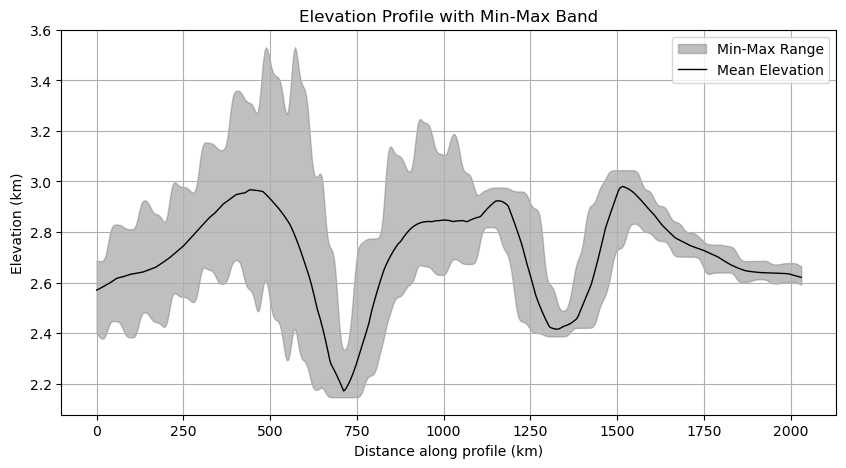

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from scipy.spatial import cKDTree
from scipy.interpolate import RegularGridInterpolator, interp1d
from scipy.ndimage import gaussian_filter1d
from pyproj import Geod
from pykrige.ok import OrdinaryKriging

# File paths
coastline_shapefile = '/Applications/GPlates_2.5.0/GeoData/FeatureCollections/Coastlines/Shapefile/Global_EarthByte_GPlates_PresentDay_Coastlines_Polyline.shp'
profile_shapefile_path = '/Users/jianpingzhou/work/Papers/small_rivers/catchment/profile_Ff.shp'
file_path = '/Users/jianpingzhou/work/Papers/Andean-type/data/Whole_E_Asia.csv'

# Load coastline
coastline_gdf = gpd.read_file(coastline_shapefile)

# Load paleo elevation data
df = pd.read_csv(file_path)
df['Predicted_Paleo_Elevation'] = df['Predicted_Paleo_Elevation'].astype(float)
df = df[(df['Age'] >= 130) & (df['Age'] <= 140)]

# Group data by Age, Lat, Lon
grouped = (
    df.groupby(['Age', 'Lat', 'Lon'])['Predicted_Paleo_Elevation']
    .agg(['median', 'std'])
    .reset_index()
    .rename(columns={'median': 'Median_Predicted_Paleo_Elevation', 'std': 'Error_Predicted_Paleo_Elevation'})
)

# Kriging interpolation
def interpolate_paleo_elevation_kriging(df, resolution=100):
    lon_min, lon_max = 105, 140  # Interpolation area longitude bounds
    lat_min, lat_max = 10, 55    # Interpolation area latitude bounds

    lon_grid = np.linspace(lon_min, lon_max, resolution)
    lat_grid = np.linspace(lat_min, lat_max, resolution)

    points_lon = df['Lon'].values
    points_lat = df['Lat'].values
    values = df['Median_Predicted_Paleo_Elevation'].values

    kriging_model = OrdinaryKriging(
        points_lon, points_lat, values,
        variogram_model='spherical',
        verbose=False, enable_plotting=False
    )

    paleo_elevation_grid, _ = kriging_model.execute('grid', lon_grid, lat_grid)
    return lon_grid, lat_grid, paleo_elevation_grid

# Extract elevation profile sampling all cells along the polyline
def extract_elevation_profile(shapefile_path, lon_grid, lat_grid, paleo_elevation_grid):
    profile_gdf = gpd.read_file(shapefile_path)
    if profile_gdf.geometry.iloc[0].geom_type != 'LineString':
        raise ValueError("Shapefile must contain a LineString geometry.")
    
    line = profile_gdf.geometry.iloc[0]
    num_samples = 500  # Increase sample points along the line
    profile_points = np.array([line.interpolate(i / num_samples, normalized=True).coords[0] for i in range(num_samples + 1)])
    
    interp_func = RegularGridInterpolator((lat_grid, lon_grid), paleo_elevation_grid, method='linear')
    elevation_values = interp_func(profile_points[:, [1, 0]])  # Swap to (lat, lon)
    
    # Extract min and max elevation values at each profile point
    buffer_dist = 100  # Distance around the profile to extract min and max values
    min_elevations, max_elevations = [], []
    for point in profile_points:
        lat_idx = np.abs(lat_grid - point[1]).argmin()
        lon_idx = np.abs(lon_grid - point[0]).argmin()
        
        elevation_window = paleo_elevation_grid[max(0, lat_idx - 1):min(lat_idx + 2, paleo_elevation_grid.shape[0]),
                                                max(0, lon_idx - 1):min(lon_idx + 2, paleo_elevation_grid.shape[1])]
        min_elevations.append(np.nanmin(elevation_window))
        max_elevations.append(np.nanmax(elevation_window))
    
    # Smooth min and max elevations to remove sawtooth pattern
    min_elevations = gaussian_filter1d(min_elevations, sigma=2)
    max_elevations = gaussian_filter1d(max_elevations, sigma=2)
    
    geod = Geod(ellps="WGS84")
    distances = [0]
    for i in range(1, len(profile_points)):
        _, _, dist = geod.inv(profile_points[i-1][0], profile_points[i-1][1], profile_points[i][0], profile_points[i][1])
        distances.append(distances[-1] + dist / 1000)
    
    # Plot interpolation map with profile line
    plt.figure(figsize=(10, 8))
    plt.imshow(paleo_elevation_grid, extent=[lon_grid.min(), lon_grid.max(), lat_grid.min(), lat_grid.max()], origin='lower', cmap='terrain')
    plt.plot(profile_points[:, 0], profile_points[:, 1], 'r-', linewidth=2, label='Profile Line')
    plt.colorbar(label='Elevation (km)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.title('Interpolated Elevation Map with Profile Line')
    plt.show()
    
    # Plot extracted elevation profile with min-max band
    plt.figure(figsize=(10, 5))
    plt.fill_between(distances, min_elevations, max_elevations, color='gray', alpha=0.5, label='Min-Max Range')
    plt.plot(distances, elevation_values, linestyle='-', color='black', linewidth=1, label='Mean Elevation')
    plt.xlabel('Distance along profile (km)')
    plt.ylabel('Elevation (km)')
    plt.title('Elevation Profile with Min-Max Band')
    plt.grid()
    plt.legend()
    plt.show()

# Run interpolation and extract elevation profile
lon_grid, lat_grid, paleo_elevation_grid = interpolate_paleo_elevation_kriging(grouped)
extract_elevation_profile(profile_shapefile_path, lon_grid, lat_grid, paleo_elevation_grid)


In [ ]:
#Figure 5f

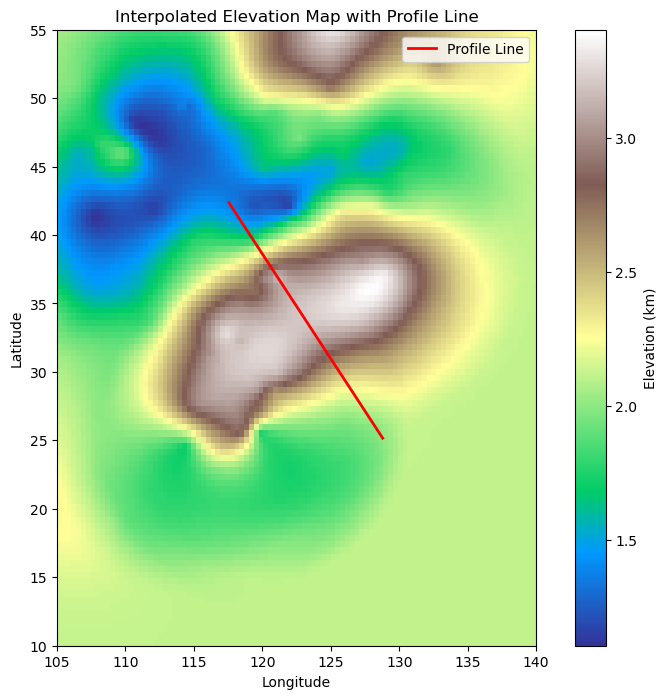

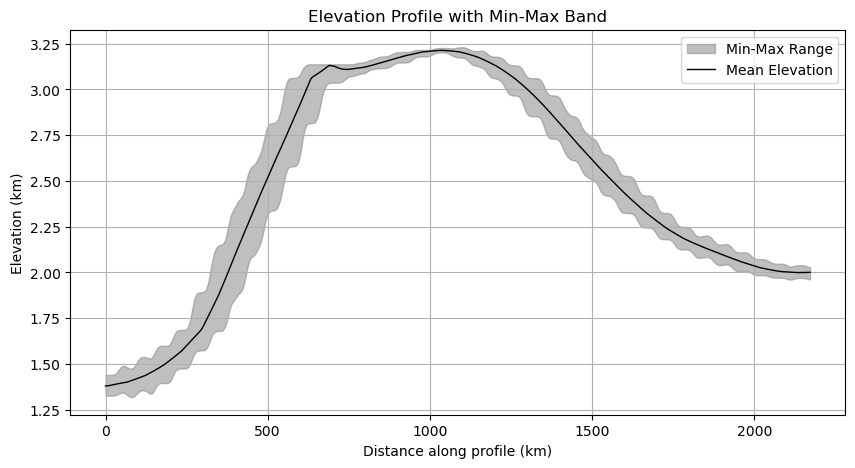

Plots saved to: ./plots


In [22]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from scipy.spatial import cKDTree
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage import gaussian_filter1d
from pyproj import Geod
from pykrige.ok import OrdinaryKriging

# File paths
coastline_shapefile = '/Applications/GPlates_2.5.0/GeoData/FeatureCollections/Coastlines/Shapefile/Global_EarthByte_GPlates_PresentDay_Coastlines_Polyline.shp'
profile_shapefile_path = '/Users/jianpingzhou/work/Papers/small_rivers/catchment/profile_Cc.shp'
file_path = '/Users/jianpingzhou/work/Papers/Andean-type/data/Whole_E_Asia.csv'

# Output directory
output_dir = "./plots"
os.makedirs(output_dir, exist_ok=True)

# Load coastline
coastline_gdf = gpd.read_file(coastline_shapefile)

# Load paleo elevation data
df = pd.read_csv(file_path)
df['Predicted_Paleo_Elevation'] = df['Predicted_Paleo_Elevation'].astype(float)
df = df[(df['Age'] >= 100) & (df['Age'] <= 120)]

# Group data by Age, Lat, Lon
grouped = (
    df.groupby(['Age', 'Lat', 'Lon'])['Predicted_Paleo_Elevation']
    .agg(['median', 'std'])
    .reset_index()
    .rename(columns={'median': 'Median_Predicted_Paleo_Elevation', 'std': 'Error_Predicted_Paleo_Elevation'})
)

# Kriging interpolation
def interpolate_paleo_elevation_kriging(df, resolution=100):
    lon_min, lon_max = 105, 140  # Interpolation area longitude bounds
    lat_min, lat_max = 10, 55    # Interpolation area latitude bounds

    lon_grid = np.linspace(lon_min, lon_max, resolution)
    lat_grid = np.linspace(lat_min, lat_max, resolution)

    points_lon = df['Lon'].values
    points_lat = df['Lat'].values
    values = df['Median_Predicted_Paleo_Elevation'].values

    kriging_model = OrdinaryKriging(
        points_lon, points_lat, values,
        variogram_model='spherical',
        verbose=False, enable_plotting=False
    )

    paleo_elevation_grid, _ = kriging_model.execute('grid', lon_grid, lat_grid)
    return lon_grid, lat_grid, paleo_elevation_grid

# Extract elevation profile
def extract_elevation_profile(shapefile_path, lon_grid, lat_grid, paleo_elevation_grid):
    profile_gdf = gpd.read_file(shapefile_path)
    if profile_gdf.geometry.iloc[0].geom_type != 'LineString':
        raise ValueError("Shapefile must contain a LineString geometry.")
    
    line = profile_gdf.geometry.iloc[0]
    num_samples = 500
    profile_points = np.array([line.interpolate(i / num_samples, normalized=True).coords[0] for i in range(num_samples + 1)])
    
    interp_func = RegularGridInterpolator((lat_grid, lon_grid), paleo_elevation_grid, method='linear')
    elevation_values = interp_func(profile_points[:, [1, 0]])
    
    N = 1
    min_elevations, max_elevations = [], []
    for point in profile_points:
        lat_idx = np.abs(lat_grid - point[1]).argmin()
        lon_idx = np.abs(lon_grid - point[0]).argmin()
        
        elevation_window = paleo_elevation_grid[max(0, lat_idx - N):min(lat_idx + N + 1, paleo_elevation_grid.shape[0]),
                                                max(0, lon_idx - N):min(lon_idx + N + 1, paleo_elevation_grid.shape[1])]
        min_elevations.append(np.nanmin(elevation_window))
        max_elevations.append(np.nanmax(elevation_window))
    
    min_elevations = gaussian_filter1d(min_elevations, sigma=2)
    max_elevations = gaussian_filter1d(max_elevations, sigma=2)
    
    geod = Geod(ellps="WGS84")
    distances = [0]
    for i in range(1, len(profile_points)):
        _, _, dist = geod.inv(profile_points[i-1][0], profile_points[i-1][1], profile_points[i][0], profile_points[i][1])
        distances.append(distances[-1] + dist / 1000)
    
    # Show and save interpolation map
    plt.figure(figsize=(10, 8))
    plt.imshow(paleo_elevation_grid, extent=[lon_grid.min(), lon_grid.max(), lat_grid.min(), lat_grid.max()], origin='lower', cmap='terrain')
    plt.plot(profile_points[:, 0], profile_points[:, 1], 'r-', linewidth=2, label='Profile Line')
    plt.colorbar(label='Elevation (km)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.title('Interpolated Elevation Map with Profile Line')
    plt.savefig(os.path.join(output_dir, 'Mid Cretaceous_interpolated_elevation_map.pdf'))
    plt.show()
    
    # Show and save extracted elevation profile
    plt.figure(figsize=(10, 5))
    plt.fill_between(distances, min_elevations, max_elevations, color='gray', alpha=0.5, label='Min-Max Range')
    plt.plot(distances, elevation_values, linestyle='-', color='black', linewidth=1, label='Mean Elevation')
    plt.xlabel('Distance along profile (km)')
    plt.ylabel('Elevation (km)')
    plt.title('Elevation Profile with Min-Max Band')
    plt.grid()
    plt.legend()
    plt.savefig(os.path.join(output_dir, 'Mid_Cretaceous elevation_profile.pdf'))
    plt.show()

# Run interpolation and extract elevation profile
lon_grid, lat_grid, paleo_elevation_grid = interpolate_paleo_elevation_kriging(grouped)
extract_elevation_profile(profile_shapefile_path, lon_grid, lat_grid, paleo_elevation_grid)

print(f"Plots saved to: {output_dir}")


In [ ]:
#Figure 5i

Original line length (degrees): 20.541951960552883
Reprojected line length (meters): 20.541951960552883


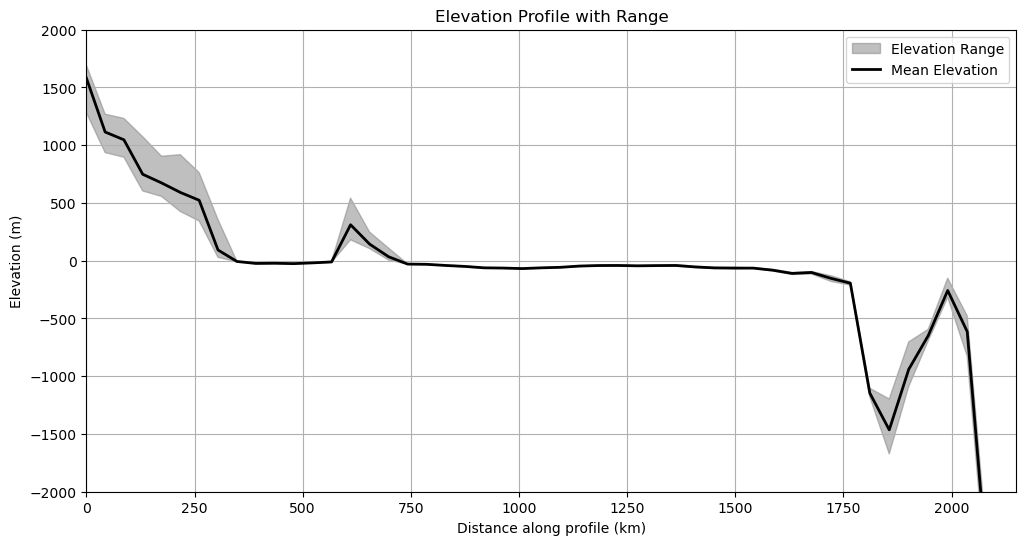

Elevation profile saved as: /Users/jianpingzhou/work/Papers/small_rivers/catchment/EA_elevation_profile01.pdf


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import LineString, Point
from shapely.ops import transform
from pyproj import CRS, Transformer, Geod

# User-defined Y-axis limit (Set to None for auto-scaling)
y_limit = (-2000, 2000)  # Example: (0, 5000) for manual scaling
x_limit = (0, 2150)  # Example: (0, 5000) for manual scaling

# Step 1: Load the profile line from the shapefile
shapefile_path = '/Users/jianpingzhou/work/Papers/small_rivers/catchment/profile_Cc.shp'
gdf = gpd.read_file(shapefile_path)

# Assuming the shapefile contains a single line geometry
profile_line = gdf.geometry[0]  # Extract the LineString

# Step 2: Open the DEM and reproject the line to match the DEM CRS
dem_path = '/Users/jianpingzhou/work/Geo_digital_earth/QGIS DATA/DEM_related/dem_downloaded/E_Asia/dem02.tif'
with rasterio.open(dem_path) as dem:
    dem_crs = dem.crs  # DEM's CRS
    
    # Transform the line to match the DEM's CRS
    source_crs = CRS(gdf.crs)  # CRS of the shapefile
    target_crs = CRS(dem_crs)
    transformer = Transformer.from_crs(source_crs, target_crs, always_xy=True)
    line_reprojected = transform(transformer.transform, profile_line)

    # Debug: Check the length before and after reprojection
    print(f"Original line length (degrees): {profile_line.length}")
    print(f"Reprojected line length (meters): {line_reprojected.length}")

    # Step 3: Sample points along the profile based on real-world distance
    num_samples = 50  # Number of sampling points along the profile
    line_length = line_reprojected.length  # Total length in DEM CRS (meters)
    
    # Generate evenly spaced distances along the line
    sampled_distances = np.linspace(0, line_length, num_samples)
    profile_points = [line_reprojected.interpolate(d) for d in sampled_distances]

    # Prepare geod object for distance calculation
    geod = Geod(ellps='WGS84')
    distances = [0]  # Store distances in km
    min_elevations = []
    mean_elevations = []
    max_elevations = []
    
    # Step 4: Extract elevation values along the profile
    for i, point in enumerate(profile_points):
        px, py = point.x, point.y  # Get point coordinates in DEM CRS
        
        # Compute distance from start using geographic coordinates
        if i > 0:
            prev_point = profile_points[i - 1]
            _, _, dist = geod.inv(prev_point.x, prev_point.y, px, py)
            distances.append(distances[-1] + dist / 1000.0)  # Convert meters to km
        
        # Convert to DEM pixel coordinates
        col, row = ~dem.transform * (px, py)  # Use (x, y) → (col, row) transformation
        row, col = int(row), int(col)  # Convert to integers

        # Debug: Check if points fall within the DEM boundaries
        if not (0 <= row < dem.height and 0 <= col < dem.width):
            print(f"Point ({px}, {py}) is out of DEM bounds, skipping.")
            min_elevations.append(np.nan)
            mean_elevations.append(np.nan)
            max_elevations.append(np.nan)
            continue
        
        # Extract elevation values around the point
        elevation_values = dem.read(1, window=((row - 5, row + 6), (col - 5, col + 6)))
        elevation_values = elevation_values[elevation_values != dem.nodata]
        
        if elevation_values.size > 0:
            min_elevations.append(elevation_values.min())
            mean_elevations.append(elevation_values.mean())
            max_elevations.append(elevation_values.max())
        else:
            min_elevations.append(np.nan)
            mean_elevations.append(np.nan)
            max_elevations.append(np.nan)

# Step 5: Plot the profile and save it as a PDF
output_pdf_path = '/Users/jianpingzhou/work/Papers/small_rivers/catchment/EA_elevation_profile01.pdf'

plt.figure(figsize=(12, 6))
plt.fill_between(distances, min_elevations, max_elevations, color='gray', alpha=0.5, label='Elevation Range')
plt.plot(distances, mean_elevations, color='black', linewidth=2, label='Mean Elevation')
plt.xlabel('Distance along profile (km)')
plt.ylabel('Elevation (m)')
plt.title('Elevation Profile with Range')
plt.legend()
plt.grid(True)

# Apply Y-axis limit if specified
if y_limit is not None:
    plt.ylim(y_limit)
# Apply X-axis limit if specified
if x_limit is not None:
    plt.xlim(x_limit)

# Save plot as PDF
plt.savefig(output_pdf_path, format='pdf', dpi=300, bbox_inches='tight')
plt.show()

print(f"Elevation profile saved as: {output_pdf_path}")
